<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/CV/3_CNN_Modernas/ejercicios/ejercicios_solucion.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

In [ ]:
%matplotlib inline

# Ejercicios Clase 3


# Introducción: Entrenando un clasificador de imágenes

Realizaremos los siguientes pasos en orden:

1. Cargar y normalizar los conjuntos de datos de entrenamiento y prueba de CIFAR10 usando ``torchvision``
2. Definir una red neuronal convolucional
3. Definir una función de pérdida
4. Entrenar a la red en los datos de entrenamiento
5. Probar la red con los datos de prueba


### 1. Cargar y normalizar CIFAR10

Usando ``torchvision``, es extremadamente fácil cargar CIFAR10.


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

La salida de los conjuntos de datos de torchvision son imágenes PILImage de rango [0, 1].
Los transformamos a Tensores de rango normalizado [-1, 1].



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Vamos a mostrar algunas de las imágenes de entrenamiento, por diversión.



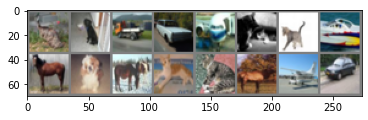

bird  dog   truck car   plane cat   cat   ship  horse dog   horse cat   cat   deer  plane car  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Definir una red neuronal convolucional

Definimos una red genérica basándonos en los conceptos de la clase 2.


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)

### 3. Definir una función de pérdida y un optimizador
Usemos una pérdida de entropía cruzada de clasificación y SGD con momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Entrenar la red

Esto es cuando las cosas comienzan a ponerse interesantes.
Simplemente tenemos que recorrer nuestro iterador de datos y alimentar las entradas a la red y optimizar.


In [ ]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    num_el = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        num_el += len(inputs)

    print(f'epoch: {epoch + 1} loss: {running_loss / num_el:.3f}')
    running_loss = 0.0

print('Finished Training')

epoch: 1 loss: 0.127
epoch: 2 loss: 0.099
epoch: 3 loss: 0.088
epoch: 4 loss: 0.080
epoch: 5 loss: 0.075
epoch: 6 loss: 0.071
epoch: 7 loss: 0.067
epoch: 8 loss: 0.064
epoch: 9 loss: 0.061
epoch: 10 loss: 0.059
Finished Training


Guardemos rápidamente nuestro modelo entrenado:


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


### 5. Probar la red con los datos de prueba

Hemos entrenado la red para 10 pases sobre el conjunto de datos de entrenamiento.
Pero necesitamos verificar si la red ha aprendido algo.

Verificaremos esto prediciendo la etiqueta de clase que la red neuronal produce como salida, y comparando con la etiqueta real. Si la predicción es
correcta, agregamos la muestra a la lista de predicciones correctas.

Bien, primer paso. Mostremos una imagen del conjunto de prueba para familiarizarnos.



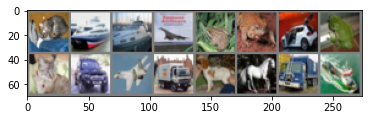

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship 


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(len(images))))


A continuación, volvamos a cargar en nuestro modelo guardado (nota: guardar y volver a cargar el modelo no era necesario aquí, solo lo hicimos para ilustrar cómo hacerlo):


In [ ]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Bien, ahora veamos qué piensa la red neuronal que son los ejemplos anteriores:

In [ ]:
outputs = net(images)

Las salidas son probabilidades para las 10 clases.
Cuanto mayor sea la probabilidad de una clase, más pensará la red que la imagen es de esa clase en particular. Entonces, obtengamos el índice de la probabilidad más alta:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(len(images))))

Predicted:  cat   ship  ship  plane deer  frog  car   frog  cat   car   plane truck frog  horse truck frog 


Los resultados parecen bastante buenos.

Veamos cómo funciona la red en todo el conjunto de prueba.



In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


Eso se ve mucho mejor que el azar, que es un 10% de precisión (elegir una clase al azar entre 10 clases). Parece que la red aprendió algo.

Hmmm, ¿cuáles son las clases que funcionaron bien y las clases que no funcionaron bien?


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device),data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 69.2 %
Accuracy for class: car   is 78.8 %
Accuracy for class: bird  is 40.0 %
Accuracy for class: cat   is 44.0 %
Accuracy for class: deer  is 60.5 %
Accuracy for class: dog   is 47.2 %
Accuracy for class: frog  is 74.7 %
Accuracy for class: horse is 63.3 %
Accuracy for class: ship  is 80.1 %
Accuracy for class: truck is 72.2 %


#  Ejercicio: Desafío abierto de CIFAR-10



En esta sección, podés experimentar con cualquier arquitectura CNN que desees en CIFAR-10.

Ahora es tu trabajo experimentar con arquitecturas, hiperparámetros, funciones de pérdida y optimizadores para entrenar un modelo que logre **al menos un 70%** de accuracy en el conjunto de validación de CIFAR-10 en 10 épocas. Podés re-utilizar todo el código que necesites de la sección anterior y del notebook de la clase grabada.

Acá está la documentación oficial de la API para cada componente del entrenamiento de una red. 

* Capas en el paquete torch.nn: http://pytorch.org/docs/stable/nn.html
* Activaciones: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Funciones de pérdida: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizadores: http://pytorch.org/docs/stable/optim.html




### Cosas que podrías probar:
* **Tamaño de kernel**: arriba usamos 5x5; ¿Serían más eficientes los kernels más pequeños?
-**Número de kernels**: arriba usamos 22 kernels. ¿Más o menos lo hacen mejor?
-**Pooling vs Strided Convolution**: ¿Utilizas el pooling máximo o simplemente convoluciones con stride?
-**Normalización por lotes**: intente agregar la normalización por lotes después de las capas de convolución ¿Tus redes se entrenan más rápido?
-**Arquitectura de red**: la red anterior tiene dos capas convolucionales. ¿Puede hacerlo mejor con una red profunda? Las buenas arquitecturas para probar incluyen:
  - [ResNets] (https://arxiv.org/abs/1512.03385) donde la entrada de la capa anterior se agrega a la salida.
  - [DenseNets] (https://arxiv.org/abs/1608.06993) donde las entradas de las capas anteriores se concatenan juntas.
  - Otras vistas en clase
-**Pooling promedio global**: en lugar de aplanar y luego tener varias capas densas, realice convoluciones hasta que su imagen se vuelva pequeña (7x7 más o menos) y luego realice una operación de pooling promedio para obtener una imagen de 1x1 (1, 1, Filter #), que luego se transforma en un vector (Filter #). Esto se utiliza en la [Red GoogleNet] (https://arxiv.org/abs/1512.00567) (consulte la Tabla 1 para conocer su arquitectura).
-**Regularización**: agregue regularización de pesos, o tal vez Dropout.

### Consejos para el entrenamiento
Para cada arquitectura de red que pruebe, debe ajustar la tasa de aprendizaje y otros hiperparámetros. Al hacer esto, hay un par de cosas importantes a tener en cuenta:

- Si los hiperparámetros funcionan bien, deberías ver una mejora en unas pocas iteraciones.
- Recordá el enfoque de grueso a fino para el ajuste de hiperparámetros: comenzá probando una amplia gama de hiperparámetros para solo unas pocas iteraciones de entrenamiento para encontrar las combinaciones de parámetros que funcionan.
- Una vez que hayas encontrado algunos conjuntos de hiperparámetros que parecen funcionar, buscá con más precisión alrededor de estos hiperparámetros. Puede que tengas que entrenar para más épocas.
- Tenés que utilizar el conjunto de validación para la búsqueda de hiperparámetros y guardarte el conjunto de prueba para evaluar tu arquitectura con los mejores parámetros seleccionados por el conjunto de validación.

### Ir más allá
Si te sentís aventurero, hay muchas otras features que podés implementar para intentar mejorar tu rendimiento.

- Optimizadores alternativos: podés probar Adam, Adagrad, RMSprop, etc.
- Funciones de activación alternativas como Leaky ReLU, PReLU, ELU o MaxOut.
- Augmentation de datos

### ¡Divertite y feliz entrenamiento!

In [ ]:
########## inserte su código aquí ############


# Constantes:
in_channel = 3
num_classes = 10
h = 32
w = 32

#Ejemplo de solución
model = nn.Sequential(
            nn.Conv2d(in_channel, 64, kernel_size=5, padding=2), # h*w
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (h//2)*(w//2)

            nn.Conv2d(64, 64, kernel_size=3, padding=1), # (h//2)*(w//2)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # ((h//2)//2)*((w//2)//2)

            nn.Conv2d(64, 256, kernel_size=3, padding=1), # ((h//2)//2)*((w//2)//2)
            nn.Conv2d(256, 256, kernel_size=1), # ((h//2)//2)*((w//2)//2)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (((h//2)//2)//2)*(((w//2)//2)//2)

            nn.Flatten(),

            nn.Linear(256*(((h//2)//2)//2)*(((w//2)//2)//2), 1000), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(1000, 100), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(100, num_classes)
        )

def Accuracy(model, loader):
    num_correct = 0
    num_samples = 0
    loss = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
    return acc


def train(model, optimizer, epochs=1):
    train_acc, valid_acc = [], []
    model = model.to(device=device)  # mueve los parámetros del modelo to CPU/GPU
    for e in range(epochs):
        print('Epoch %d' % (e))
        running_loss = 0.0
        num_el = 0
        for t, (x, y) in enumerate(trainloader):
            model.train()
            x = x.to(device=device) 
            y = y.to(device=device)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num_el += len(x)

        t_acc, v_acc = Accuracy(model, trainloader), Accuracy(model, testloader)
        train_acc.append(t_acc)
        valid_acc.append(v_acc)
        print(f'loss: {running_loss / num_el:.3f} val_acc: {v_acc}')
    return train_acc, valid_acc

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
learning_rate = 0.0015
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
tranin_loss, valid_loss = train(model, optimizer, epochs=10)

Epoch 0
loss: 0.109 val_acc: 0.4605
Epoch 1
loss: 0.086 val_acc: 0.5602
Epoch 2
loss: 0.074 val_acc: 0.6552
Epoch 3
loss: 0.065 val_acc: 0.6619
Epoch 4
loss: 0.059 val_acc: 0.7053
Epoch 5
loss: 0.054 val_acc: 0.7188
Epoch 6
loss: 0.050 val_acc: 0.7347
Epoch 7
loss: 0.046 val_acc: 0.7379
Epoch 8
loss: 0.043 val_acc: 0.7566
Epoch 9
loss: 0.040 val_acc: 0.7479


Valid Acc: 74.79


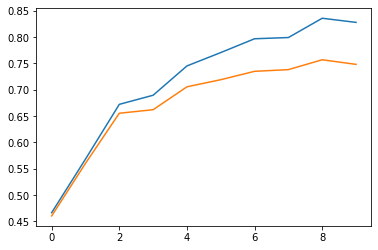

In [ ]:
import matplotlib.pyplot as plt

plt.plot(tranin_loss)
plt.plot(valid_loss)

print('Valid Acc:', valid_loss[-1]*100)